# YouTube Subtitle Analysis
Here we go and analyze subtitles fetched from YouTube.

## Imports
Import matplotlib package and configure some plot drawing variables.

In [1]:
import matplotlib.pylab as plt
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{type1cm}"

## Load data

In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../rsc/caption_party.db")
data = pd.read_sql("SELECT * from tab", conn)

data['publishedAt'] = pd.DatetimeIndex(data['publishedAt'])
data['updated'] = pd.DatetimeIndex(data['updated'])

data['viewCount'] = pd.to_numeric(data['viewCount'], downcast='unsigned')
data['commentCount'] = pd.to_numeric(data['commentCount'], downcast='unsigned', errors='coerce')

data.set_index('videoId', inplace=True)

no_subs_ids = data['subtitle'].apply(lambda x: len(x) <= 10)
data.loc[no_subs_ids, 'subtitle'] = data.loc[no_subs_ids, 'description']

## Variables
### Dates and periods

In [3]:
from datetime import datetime as time, timedelta
import pytz

cest = pytz.timezone("Europe/Berlin")

bt_election = time.fromisoformat('2017-09-24').replace(tzinfo=cest)
eu_election = time.fromisoformat('2019-05-26').replace(tzinfo=cest)

bt_start = bt_election - timedelta(days=90)
eu_start = eu_election - timedelta(days=90)
bt_end = bt_election + timedelta(days=90)
eu_end = eu_election + timedelta(days=90)

bt_period = (bt_start <= data['publishedAt']) & (data['publishedAt'] <= bt_end)
eu_period = (eu_start <= data['publishedAt']) & (data['publishedAt'] <= eu_end)

bt_data = data[bt_period]
eu_data = data[eu_period]

### Parties and elections

In [4]:
parties = ['union', 'spd', 'afd', 'fdp', 'linke', 'grüne']
elections = ['bt', 'eu']

### Colors

In [5]:
import matplotlib.colors as mc
import colorsys

def scale_color(color, amount=0.5):
    c_hls = colorsys.rgb_to_hls(*mc.to_rgb(color))
    c_rgb = colorsys.hls_to_rgb(c_hls[0], 1 - amount * (1 - c_hls[1]), c_hls[2])
    return mc.to_hex(c_rgb)

colors = {
    'union': '#252422',
    'spd':   '#e2001a',
    'afd':   '#009ee0',
    'fdp':   '#ffec01',
    'linke': '#ffa7b6',
    'grüne': '#42923b'}

colors_light = {key: scale_color(color, 0.35) for key, color in colors.items()}

## Methods

### Cleaning and tokenization

1. Replaces `<numbers>` by single space
2. Replaces `<letter>-<letter>` by `<letter><letter>`
2. Replaces `<letter>*<letter>` by `<letter><letter>`
3. Replaces `<non-words>-<newline><non-words>` by nothing
4. Replaces `<non-words><newline><non-words>` by single space
5. Replaces `<non-words>` by single space

In [6]:
import re

def clean_and_tokenize(text):
    replaced = re.sub(r'\d+', ' ', text)
    replaced = re.sub(r'(\w)-(\w)', r'\1\2', replaced)
    replaced = re.sub(r'(\w)\*(\w)', r'\1\2', replaced)
    replaced = re.sub(r'\W*-\\n\W*', '', replaced)
    replaced = re.sub(r'\W*\\n\W*', ' ', replaced)
    replaced = re.sub(r'\W+', ' ', replaced)
    return replaced.split()

### Stop words

In [7]:
from nltk.corpus import stopwords

stop = set(stopwords.words('german'))

def test_stop_word(word, mode='all'):
    return (word.lower() in stop) or (word.capitalize() in stop)

### Dictionary

In [8]:
from enchant import Dict

dic = Dict("de_DE")

def test_dictionary(word):
    return dic.check(word.lower()) or dic.check(word.capitalize())

### Lemmatization

#### Spacy

In [9]:
from spacy.lang.de import lemmatizer

def lemmatize_spacy(word):
    try:
        return lemmatizer.LOOKUP[word]
    except: pass
    
    # Try to lemmatize lower word version
    try:
        return lemmatizer.LOOKUP[word.lower()]
    except: pass
    
    # Try to lemmatize capitalized word version
    try:
        return lemmatizer.LOOKUP[word.capitalize()]
    except: pass

#### Treetagger

In [10]:
from treetaggerwrapper import TreeTagger

tagger = TreeTagger(TAGLANG='de')

def lemmatize_tt(word):
    
    def lemmatize(w):
        tt_lower = tagger.tag_text([w], tagonly=True)[0].split('\t')[-1]
        if tt_lower != w:
            return tt_lower.split("|")[-1]
    
    lem = lemmatize(word)
    if lem is not None:
        return lem
    
    # Try to lemmatize lower word version
    lem = lemmatize(word.lower())
    if lem is not None:
        return lem
    
    # Try to lemmatize capitalized word version
    lem = lemmatize(word.capitalize())
    if lem is not None:
        return lem

/usr/lib/python3.7/site-packages/treetaggerwrapper.py:740: FutureWarning: Possible nested set at position 8
  re.IGNORECASE | re.VERBOSE)
/usr/lib/python3.7/site-packages/treetaggerwrapper.py:2044: FutureWarning: Possible nested set at position 152
  re.VERBOSE | re.IGNORECASE)
/usr/lib/python3.7/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/usr/lib/python3.7/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


#### Lemmatizer combiner
- If one lemmatizer exclusively modifies the word, it returns this lemmatized version
- If both lemmatizer modify the word, it returns the spaCy version
- If neither one modifies the word, it returns just the word

In [11]:
def lemmatize_combined(word):
    sp = lemmatize_spacy(word)
    tt = lemmatize_tt(word)
    if sp is not None:
        return sp
    elif tt is not None:
        return tt
    else:
        return word

### Visualization

In [22]:
from matplotlib.ticker import MaxNLocator
from itertools import chain
from IPython.display import display_html
import pandas as pd

def plot_bar(data, label):
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    ax.set_ylabel(label);

    color_map = [colors[party] for party in parties]
    ax.bar(parties, channel_count[parties], color=color_map, width=.8)
    return fig


def plot_compare_bar(bt_data, eu_data, label):
    """ Returns a figure where two grouped DataFrames are compared in a bar chart.
    """
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylabel(label);
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    color_map_dark = [colors[party] for party in parties]
    color_map_light = [colors_light[party] for party in parties]
    ax.bar(parties, [bt_data[party] for party in parties], color=color_map_dark, width=-.4, align='edge', label='Bundestag election')
    ax.bar(parties, [eu_data[party] for party in parties], color=color_map_light, width=.4, align='edge', label='European election')
    return fig


def generate_wordcloud(weight_matrix, title):
    """ The following function takes a weight matrix as an input with parties as columns and words as indices.
    """
    fig, axs = plt.subplots(3, 2, figsize=(18, 15))
    plt.suptitle(title, size=25, weight='bold')
    axis = chain.from_iterable(zip(*axs))
    for party, ax in zip(weight_matrix.columns, axis):
        # Visuals
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title(party.upper(), size=20)
        color_func = lambda *args, **kwargs: colors[party]
        # Weights and Clourd
        word_weights = top_n(weight_matrix, party, 30).iloc[:,0].to_dict()
        word_cloud = WordCloud(background_color='white', height=500, width=1000, color_func=color_func)
        image = word_cloud.generate_from_frequencies(word_weights)
        ax.imshow(image, interpolation='bilinear')
    return fig

        
def display_side_by_side(*args):
    """ Displays mutiple panda DataFrames side by side.
    """
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
    
def top_n(df, column, n):
    """ Sorts a pandas DataFrame and returns the first n entries of a specific column.
    """
    return df[[column]].sort_values(ascending=False, by=column).iloc[:n]

### Corpus

In [13]:
def get_yt_text(party, election):
    party_vec = (data['party'] == party)
    if election == 'bt':
        subs = data[bt_period & party_vec]['subtitle']
    elif election == 'eu':
        subs = data[eu_period & party_vec]['subtitle']
    else: subs = data[party_vec]['subtitle']
        
    text = ""
    for sub in subs:
        text += " " + sub
    return text
                

def merged_corpus(party, election, 
                  filters=[], 
                  lemmatize=True, 
                  lowercase=True, 
                  min_chars=0):
    # Fetch relevant data
    if election == 'all':
        raw_text = ' '.join([get_yt_text(party, e) for e in elections])
    else:
        raw_text = get_yt_text(party, election)
        
    # Cleaning & tokenization
    tokens = clean_and_tokenize(raw_text)
    
    filtered_tokens = []
    for token in tokens:
        # Min char removal
        if len(token) < min_chars:
            continue
            
        # Stop word removal
        if test_stop_word(token):
            continue
            
        # Additional filters 
        if not all(f(token) for f in filters):
            continue 
            
        # Lemmatization
        lem_token = token
        if lemmatize:
            lem_token = lemmatize_combined(token)
        
        # Lowercasing
        if lowercase:
            lem_token = lem_token.lower()
            
        filtered_tokens.append(lem_token)
        
    return filtered_tokens

## Plotting
### Corpus size

### Get corpus

In [14]:
corpus_bt = {party: merged_corpus(party, 'bt', min_chars=4) for party in parties}
corpus_eu = {party: merged_corpus(party, 'eu', min_chars=4) for party in parties}

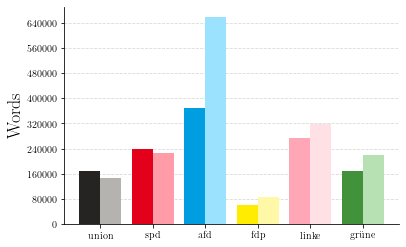

In [23]:
bt_sub_words = {party: len(corpus_bt[party]) for party in parties}
eu_sub_words = {party: len(corpus_eu[party]) for party in parties}

fig = plot_compare_bar(bt_sub_words, eu_sub_words, 'Words')

fig.savefig('outputs/yt-party-words.pdf', bbox_inches = 'tight', pad_inches = 0)

## Topic analysis algorithms
### tf-idf

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

v_bt = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', norm='l1')
x_bt = v_bt.fit_transform(" ".join(corpus_bt[party]) for party in parties)
df_bt = pd.DataFrame(x_bt.T.toarray(), index=v_bt.get_feature_names(), columns=parties)
display_side_by_side(*(top_n(df_bt, party, 15) for party in parties))

,union
bayernplan,0.000206
landesleitung,0.000190
land,0.000187
jahr,0.000187
geben,0.000187
schon,0.000186
vorpommern,0.000186
gehen,0.000185
ganz,0.000184
mussen,0.000184


In [37]:
v_eu = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', norm='l1')
x_eu = v_eu.fit_transform(" ".join(corpus_eu[party]) for party in parties)
df_eu = pd.DataFrame(x_eu.T.toarray(), index=v_eu.get_feature_names(), columns=parties)
display_side_by_side(*(top_n(df_eu, party, 15) for party in parties))

,union
arbeitskammer,0.000266
daul,0.000226
ausbildungsvorbereitung,0.000208
europa,0.000208
handelsvertrag,0.000204
hochschulzulassung,0.000204
saarlandisch,0.000202
schon,0.000202
geben,0.000201
ganz,0.000200


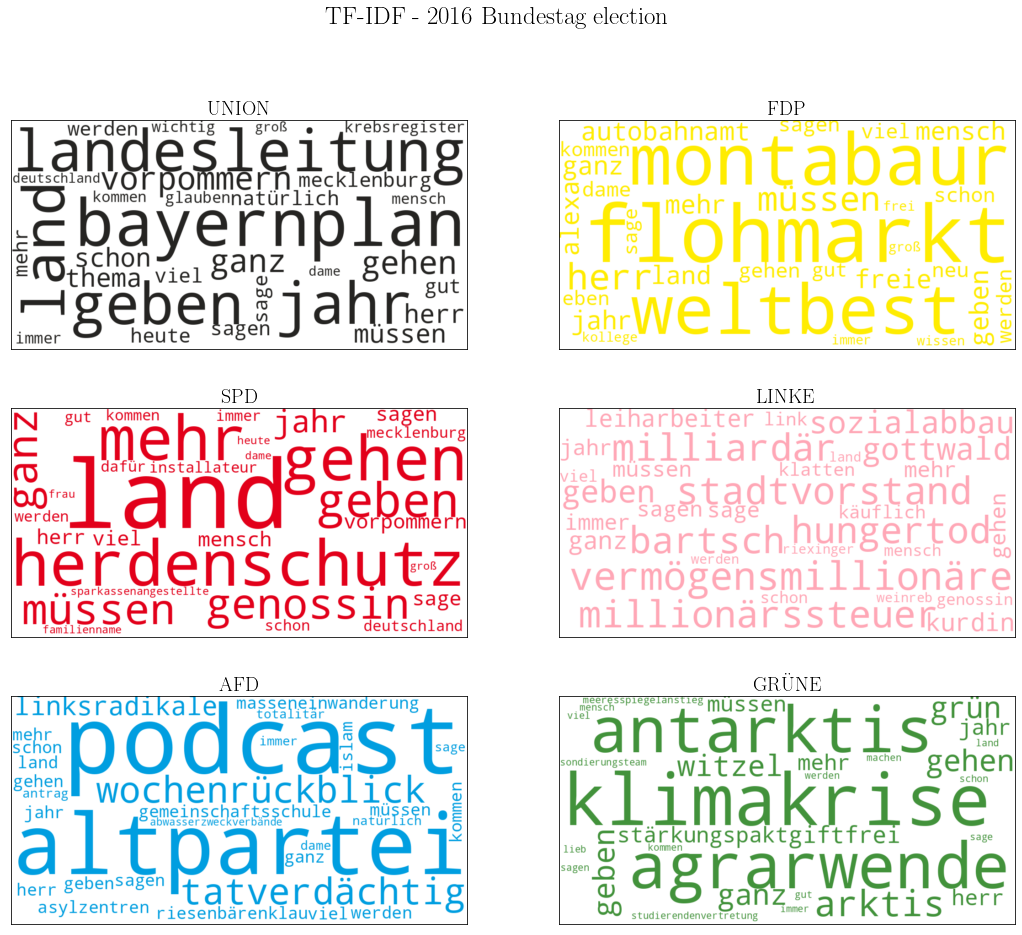

In [30]:
from wordcloud import WordCloud

fig = generate_wordcloud(df_bt, "TF-IDF - 2016 Bundestag election")
fig.savefig('outputs/yt-tfidf-bt-wordcloud.pdf', bbox_inches = 'tight', pad_inches = 0)

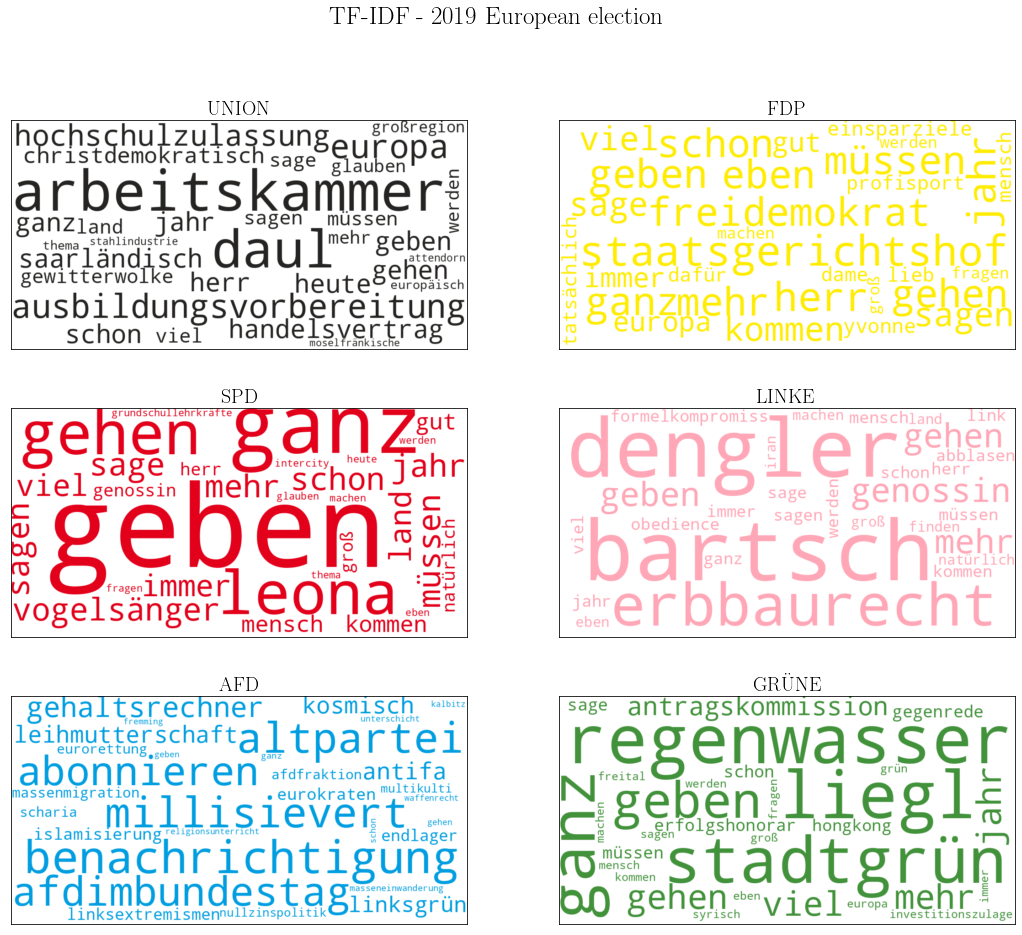

In [31]:
fig = generate_wordcloud(df_eu, "TF-IDF - 2019 European election")
fig.savefig('outputs/yt-tfidf-eu-wordcloud.pdf', bbox_inches = 'tight', pad_inches = 0)

## LDA

In [ ]:
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.visualize import plot_eval_results
from tmtoolkit.topicmod.evaluate import results_by_parameter

## Old stuff

In [ ]:
# Dictionary filtering
dic = enchant.Dict("de_DE")
dic_filtered = {party: (word.capitalize() for word in raws[party].split() if not dic.check(word.lower()) and word.isalpha()) for party in parties}
import spacy 
# Stemming and lemmatization
nlp = spacy.load('de', disable=['parser', 'ner', 'tagger'])
nlp.max_length = 30_000_000

normalized = {party: (nlp(word)[0]
                      for word in dic_filtered[party]) for party in parties}
# Stop words removal
stop = set(stopwords.words('german'))

custom_stop = ["dass", "sagen", "mal", "ganz", "ja", "all", "immer",
               "müssen", "schon", "geben", "gut", "deshalb", "brauchen", "damen", "herren"]
corpus = {party: [w.lemma_ for w in normalized[party]
                  if w.lemma_ not in stop
                  and w.lemma_ not in custom_stop
                  and len(w.lemma_) > 3
                  and w.is_alpha]
          for party in parties}

In [ ]:
def tfidf(fdists, name):
    """Term frequency - inverse document frequency."""

    def tf(token, fdist):
        return 0.5 + (0.5 * fdist.get(token))/fdist.most_common(1)[0][1]

    def idf(token):
        return math.log2(len(corpus)/(sum(1 for key in fdists.keys() if fdists.get(key).get(token) is not None)))
    fdist = fdists.get(name)
    return [(token, tf(token, fdist) * idf(token)) for token in fdist.keys()]


In [ ]:
# Word frequency
fdists = {party: nltk.FreqDist(
    [w for w in corpus[party] if dic.check(w)]) for party in parties}
# for party in parties:
#     fdist = fdists[party]
#     plt.figure()
#     fdist.plot(20)

# TF-IDF
tfidfs = {party: tfidf(fdists, party) for party in parties}
my_weights = {party: my_weighting(fdists, party) for party in parties}

In [ ]:
from itertools import chain

fig, axs = plt.subplots(3, 2, figsize=(15, 30))
axis = chain.from_iterable(zip(*axs))
for party, ax in zip(parties, axis):
    ax.axis("off")
    ax.set_title(party.upper())
    word_weights = sorted(
        tfidfs[party], reverse=True, key=lambda x: x[1])[:30]
    wordcloud = WordCloud(background_color='white', max_font_size=25, height=100).generate_from_frequencies(
        dict(word_weights))
    ax.imshow(wordcloud, interpolation='bilinear')


